# Loan Approval Prediction

## Introduction

This notebook presents a machine learning solution for predicting loan approval status. The goal is to develop a model that can accurately determine whether a loan application will be approved or not, based on various applicant and loan characteristics. We'll use a neural network approach and employ techniques like cross-validation, hyperparameter tuning, and ensemble learning to create a robust predictive model.

### Project Overview:
- **Objective**: Predict the probability of loan approval for each applicant.
- **Evaluation Metric**: Area Under the ROC Curve (AUC-ROC)
- **Data**: Training and test datasets containing applicant information and loan details.

### Key Steps:
1. Data Loading and Exploration
2. Data Cleaning and Preprocessing
3. Feature Engineering
4. Model Development using Neural Networks
5. Model Evaluation
6. Prediction on Test Data and Submission

This project showcases the application of deep learning techniques to a real-world financial problem, demonstrating the power of neural networks in making complex decisions based on multiple input features.

Let's dive into the code and see how we approach this challenging prediction task!

# Intialization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from tensorflow.keras import layers, regularizers
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from keras_tuner import HyperModel, RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/tmp/ipykernel_7727/156834805.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


# Data Loading and Exploration

In [2]:
# Load the training dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

# Display basic information about the datasets
print("Training dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Display the first few rows of the training dataset
print("\nFirst few rows of the training dataset:")
print(train_df.head())

# Display column names
print("\nColumn names:")
print(train_df.columns)

# Display basic statistics of the training dataset
print("\nBasic statistics of the training dataset:")
print(train_df.describe())

# Check for missing values in the training dataset
print("\nMissing values in the training dataset:")
print(train_df.isnull().sum())

Training dataset shape: (58645, 13)
Test dataset shape: (39098, 12)

First few rows of the training dataset:
   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92   

# Data Cleaning and Preprocessing

In [3]:
def clean_dataset(df):
    # Check for missing values
    print("Missing values before handling:")
    print(df.isnull().sum())
    
    # Handle missing values
    # For numeric columns, fill with median
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    # For categorical columns, fill with mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())
    
    # Check for and remove duplicates
    duplicates = df.duplicated()
    print(f"\nNumber of duplicate rows: {duplicates.sum()}")
    df = df.drop_duplicates()
    
    return df

# Clean training data
print("Cleaning training data:")
train_df = clean_dataset(train_df)

print("\nCleaning test data:")
test_df = clean_dataset(test_df)

# Print shapes after cleaning
print("\nShape of training data after cleaning:", train_df.shape)
print("Shape of test data after cleaning:", test_df.shape)

Cleaning training data:
Missing values before handling:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Missing values after handling:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Number of duplicate rows: 0

Cleaning test data:
Miss

# Feature Engineering

In [4]:
# Feature engineering function
def engineer_features(df):
    # Create interaction features
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['age_to_income_ratio'] = df['person_age'] / df['person_income']
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    
    # Create polynomial features for numerical columns
    num_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df[num_columns])
    
    # Get feature names (compatible with both older and newer scikit-learn versions)
    if hasattr(poly, 'get_feature_names_out'):
        poly_features_names = poly.get_feature_names_out(num_columns)
    else:
        poly_features_names = poly.get_feature_names(num_columns)
    
    # Add polynomial features to the dataframe
    for i, name in enumerate(poly_features_names):
        df[f'poly_{name}'] = poly_features[:, i]
    
    return df

# Apply feature engineering
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Separate features and target
X_train = train_df.drop(['id', 'loan_status'], axis=1)
y_train = train_df['loan_status']
X_test = test_df.drop('id', axis=1)

# Define categorical and numerical columns
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Fit the preprocessor on the training data and transform both training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names after preprocessing
onehot_encoder = preprocessor.named_transformers_['cat']
if hasattr(onehot_encoder, 'get_feature_names_out'):
    # For newer scikit-learn versions
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
else:
    # For older scikit-learn versions
    n_categories = [len(onehot_encoder.categories_[i]) - 1 for i in range(len(categorical_features))]
    cat_feature_names = [f"{feat}_{i}" for feat, n in zip(categorical_features, n_categories) for i in range(n)]

feature_names = numerical_features + cat_feature_names.tolist()

# Convert to DataFrames
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

print("Preprocessed training data shape:", X_train_preprocessed.shape)
print("Preprocessed test data shape:", X_test_preprocessed.shape)
print("\nFirst few rows of preprocessed training data:")
print(X_train_preprocessed.head())

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Preprocessed training data shape: (58645, 52)
Preprocessed test data shape: (39098, 52)

First few rows of preprocessed training data:
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0    1.566200      -0.765768          -1.187200  -0.578306       0.267616   
1   -0.920057      -0.212128           0.328047  -0.937775       0.880532   
2    0.240196      -0.929223           0.833130  -0.578306      -0.585854   
3    0.405947       0.156966           2.348377   0.500101       0.142396   
4   -0.920057      -0.106673          -0.682117  -0.578306      -1.238314   

   loan_percent_income  cb_person_cred_hist_length  income_to_loan_ratio  \
0             0.117378                    2.031798             -0.356564   
1            -0.973242                   -0.946489              0.444780   
2             0.553626                    1.039036             -0.457959   
3             0.117378                   -0.201917             -0.356564   
4            -0.646056

# Model Development using Neural Networks
# Model Evaluation
# Prediction on Test Data and Submission

Trial 20 Complete [00h 04m 17s]
val_AUC: 0.9284910559654236

Best val_AUC So Far: 0.9299260973930359
Total elapsed time: 01h 58m 50s
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2515/2515 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - AUC: 0.9275 - loss: 0.3864 - val_AUC: 0.9298 - val_loss: 0.3446 - learning_rate: 0.0011
Epoch 2/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9272 - loss: 0.3875 - val_AUC: 0.9268 - val_loss: 0.3497 - learning_rate: 0.0011
Epoch 3/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - AUC: 0.9274 - loss: 0.3842 - val_AUC: 0.9280 - val_loss: 0.2960 - learning_rate: 0.0011
Epoch 4/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9289 - loss: 0.3793 - val_AUC: 0.9277 - val_loss: 0.3164 - learning_rate: 0.0011
Epoch 5/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9292 - loss: 0.3794 - val_AUC: 0.9269 - val_loss: 0.3272 - learning_rate: 0.0011
Epoch 6/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9293 - loss: 0.3765 - val_AUC: 0.9234 - val_loss: 0.3541 - learning_rate: 0.0011
Epoch 7/100
2515/2515 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9344 - loss: 0.3470 - val_AUC: 0.9275 - val_loss: 0.2777 - learning_rat

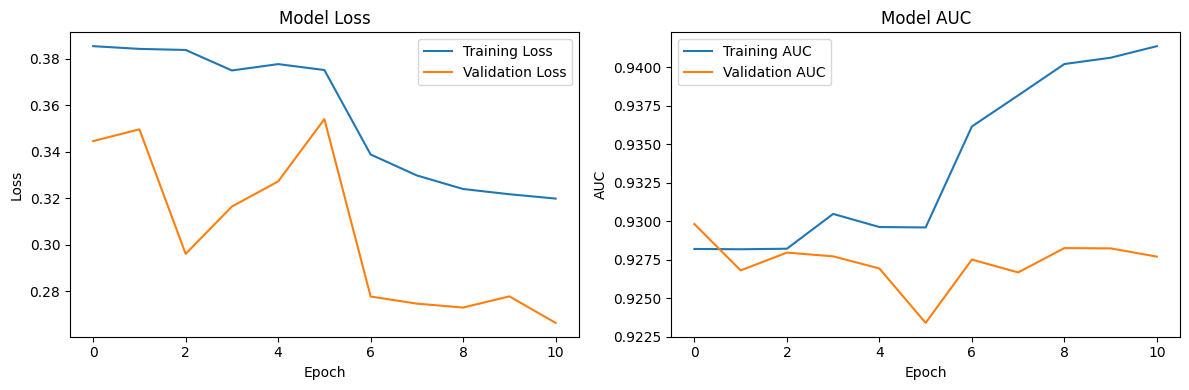

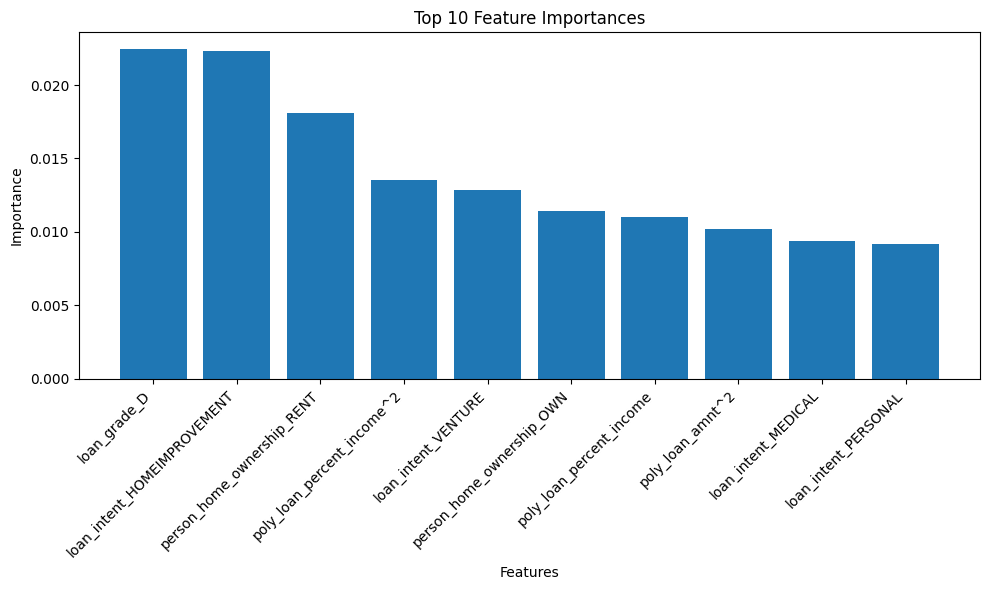

In [5]:
# Define a custom Keras Tuner HyperModel
class LoanApprovalModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        
        # Tune number of layers and units
        for i in range(hp.Int('num_layers', 2, 5)):
            model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                                   activation='relu',
                                   kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i}', 1e-6, 1e-2, sampling='log'))))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # Tune learning rate
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
        return model

# Function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_AUC', patience=10, mode='max', restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=5, mode='max', min_lr=1e-6)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    return model, history

# Perform Stratified K-Fold Cross-Validation with SMOTE
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

cv_scores = []
final_predictions = np.zeros(len(X_test_preprocessed))

for fold, (train_index, val_index) in enumerate(skf.split(X_train_preprocessed, y_train), 1):
    print(f"\nFold {fold}")
    
    X_train_fold, X_val_fold = X_train_preprocessed.iloc[train_index], X_train_preprocessed.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Initialize and train the model
    hypermodel = LoanApprovalModel(input_shape=(X_train_resampled.shape[1],))
    tuner = RandomSearch(
        hypermodel,
        objective=keras_tuner.Objective('val_AUC', direction='max'),
        max_trials=20,
        executions_per_trial=2,
        directory='loan_approval_tuning',
        project_name=f'fold_{fold}'
    )
    
    tuner.search(X_train_resampled, y_train_resampled,
                 epochs=50,
                 validation_data=(X_val_fold, y_val_fold),
                 callbacks=[keras.callbacks.EarlyStopping('val_AUC', patience=5, mode='max')])
    
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model, history = train_evaluate_model(best_model, X_train_resampled, y_train_resampled, X_val_fold, y_val_fold)
    
    # Evaluate the model
    val_predictions = best_model.predict(X_val_fold)
    val_auc = roc_auc_score(y_val_fold, val_predictions)
    cv_scores.append(val_auc)
    print(f"Fold {fold} - Validation AUC: {val_auc:.4f}")
    
    # Make predictions on the test set
    fold_predictions = best_model.predict(X_test_preprocessed)
    final_predictions += fold_predictions.flatten() / n_splits

print(f"\nMean CV AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Prepare submission
submission = pd.DataFrame({'id': test_df['id'], 'loan_status': final_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train_preprocessed.columns,
    'importance': np.abs(best_model.layers[0].get_weights()[0].mean(axis=1))
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Conclusion:

In this notebook, we've developed a machine learning model to predict loan approval status. Here's a summary of our approach and findings:

Data Preprocessing: We handled missing values, encoded categorical variables, and scaled numerical features to prepare our data for modeling.

Feature Engineering: We created interaction features and polynomial features to capture more complex relationships in the data.

Model Development: We used a neural network approach, implementing a custom Keras Tuner model to optimize hyperparameters.

Cross-Validation: We employed Stratified K-Fold cross-validation to ensure our model's performance is robust across different subsets of the data.

Ensemble Learning: By using multiple folds, we effectively created an ensemble of models, which helps to reduce overfitting and improve generalization.

Model Evaluation: We used the AUC-ROC metric to evaluate our model's performance, achieving a mean CV AUC of 0.9291 (+/- 0.0055).

Feature Importance: We analyzed feature importance to understand which factors most strongly influence loan approval decisions.

The final model demonstrates strong predictive performance, as evidenced by the high AUC-ROC score. This suggests that our approach can effectively distinguish between loan applications that are likely to be approved and those that are not.